In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
CME_datetime_format = "%Y%m%d%H%M%S%f"

In [3]:
symbol = 'ESH2'
month = '01'
day = '03'
datestr = "2022"+month+day
data_path = 'C:/data/CME/2022/%s/%s/MBO/XCME/'%(month, day)
order_file = data_path + symbol + '_orders.csv'
prefix_file = data_path + symbol + '_prefix.csv'
suffix_file = data_path + symbol + '_suffix.csv'
print(order_file, prefix_file, suffix_file)

start = pd.to_datetime('{0} 13:00:00'.format(datestr))
end = pd.to_datetime('{0} 21:00:00'.format(datestr))

C:/data/CME/2022/01/03/MBO/XCME/ESH2_orders.csv C:/data/CME/2022/01/03/MBO/XCME/ESH2_prefix.csv C:/data/CME/2022/01/03/MBO/XCME/ESH2_suffix.csv


In [4]:
def load_lit_orders(order_file, prefix=None, suffix=None):
    orders = pd.read_csv(order_file, parse_dates=['TRANSACTTIME'], date_parser=lambda x: pd.to_datetime(x, format=CME_datetime_format))
    if prefix is not None:
        prefix_df = pd.read_csv(prefix, parse_dates=['TRANSACTTIME'], date_parser=lambda x: pd.to_datetime(x, format=CME_datetime_format))
        orders = pd.concat([prefix_df, orders])
    if suffix is not None:
        suffix_df = pd.read_csv(suffix, parse_dates=['TRANSACTTIME'], date_parser=lambda x: pd.to_datetime(x, format=CME_datetime_format))
        orders = pd.concat([orders, suffix_df])
    columns = ['TRANSACTTIME', 'PUBLIC_ORDER_ID', 'EXECTYPE', 'SIDE', 'PRICE', 'VISIBLEQTY']
    df = orders[columns].reset_index().sort_values(['TRANSACTTIME', 'index']).set_index('TRANSACTTIME').iloc[:, 1:]
    df['EXECTYPE'] = df['EXECTYPE'].apply(lambda x: 'Insert' if x ==0 else ('Amend' if x == 1 else 'Cancel'))
    df['SIDE'] = df['SIDE'].apply(lambda x: 'Buy' if x == 0 else 'Sell')
    df['PUBLIC_ORDER_ID'] = df['PUBLIC_ORDER_ID'].astype(str)
    return df

In [5]:
orders_df = load_lit_orders(order_file, prefix=prefix_file, suffix=None)
orders_df = orders_df.loc[start:end]

In [6]:
insert_df = orders_df[orders_df['EXECTYPE'] == 'Insert']
insert_ = insert_df.reset_index()
insert_['hour'] = insert_['TRANSACTTIME'].apply(lambda x: x.hour)
insert_['minute'] = insert_['TRANSACTTIME'].apply(lambda x: x.minute)

insert_['time_diff'] = insert_['TRANSACTTIME'].diff()
insert_time_diff = insert_['time_diff'].dropna().values.astype('float64')
len(insert_time_diff)

buy_ = insert_[insert_['SIDE'] == 'Buy'].copy()
buy_['time_diff'] = buy_['TRANSACTTIME'].diff()
buy_time_diff = buy_['time_diff'].dropna().values.astype('float64')
sell_ = insert_[insert_['SIDE'] == 'Sell'].copy()
sell_['time_diff'] = sell_['TRANSACTTIME'].diff()
sell_time_diff = sell_['time_diff'].dropna().values.astype('float64')

In [7]:
np.mean(insert_time_diff), np.max(insert_time_diff)

(9235951.820580717, 5094674902.0)

In [65]:
insert_.sort_values('time_diff')

,TRANSACTTIME,PUBLIC_ORDER_ID,EXECTYPE,SIDE,PRICE,VISIBLEQTY,time_diff,hour,minute,float_time_diff
2687267,2022-01-03 19:36:40.230025935,649200912501,Insert,Sell,477725.0,1,0 days 00:00:00,19,36,NaN
1542945,2022-01-03 15:52:28.035622787,649199355455,Insert,Sell,477100.0,1,0 days 00:00:00,15,52,NaN
1542948,2022-01-03 15:52:28.035636075,649199355458,Insert,Sell,477100.0,2,0 days 00:00:00,15,52,NaN
1547301,2022-01-03 15:53:02.390161899,649199361243,Insert,Sell,477075.0,1,0 days 00:00:00,15,53,NaN
1542949,2022-01-03 15:52:28.035636075,649199355459,Insert,Sell,477100.0,1,0 days 00:00:00,15,52,NaN
...,...,...,...,...,...,...,...,...,...,...
5957,2022-01-03 13:08:57.678130137,649197180298,Insert,Sell,478400.0,2,0 days 00:00:04.108689546,13,8,4.108690e+09
12602,2022-01-03 13:17:34.468875825,649197190765,Insert,Sell,478475.0,1,0 days 00:00:04.201599924,13,17,4.201600e+09
34186,2022-01-03 13:40:40.945452317,649197223853,Insert,Sell,478250.0,1,0 days 00:00:04.225482356,13,40,4.225482e+09
33953,2022-01-03 13:40:19.490955141,649197223463,Insert,Buy,478250.0,1,0 days 00:00:05.094674902,13,40,5.094675e+09


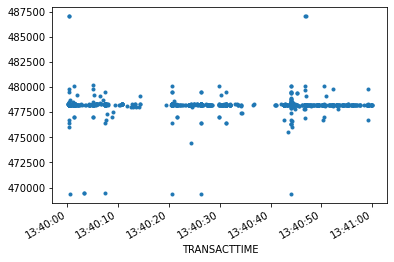

In [105]:
insert_.set_index('TRANSACTTIME').loc['2022-01-03 13:40']['PRICE'].plot(style='.')

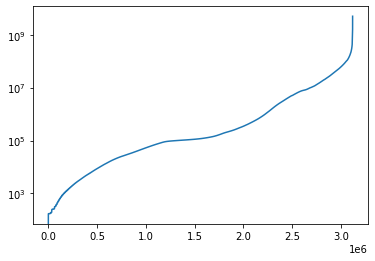

In [76]:
pd.Series(np.sort(insert_time_diff)).plot(logy=True)

In [78]:
# keep the 99 quantile
np.quantile(insert_time_diff, 0.95)

46936091.20000002

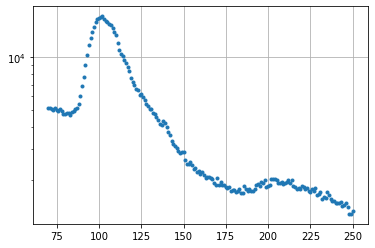

In [98]:
pd.Series(insert_time_diff.round(-3)/1e3).value_counts().sort_index().loc[70:250].plot(logy=True, style='.', grid=True)

In [8]:
np.quantile(insert_time_diff, [0.25, 0.5, 0.75])*1e-6

array([0.027106, 0.117726, 2.159146])

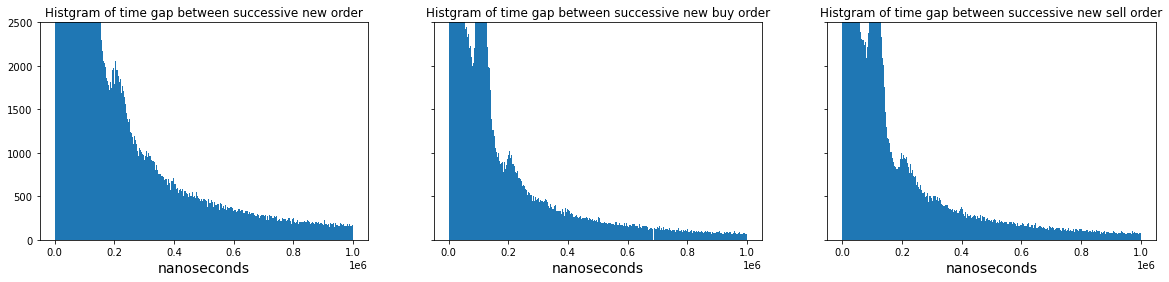

In [99]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4), sharey=True)
bins = np.linspace(0, 1000000, 1001)

ax[0].hist(insert_time_diff, bins=bins)
ax[0].set_ylim((0, 2500))
ax[0].set_title('Histgram of time gap between successive new order')
ax[0].set_xlabel('nanoseconds', size=14)

ax[1].hist(buy_time_diff, bins=bins)
ax[1].set_title('Histgram of time gap between successive new buy order')
ax[1].set_xlabel('nanoseconds', size=14)

ax[2].hist(sell_time_diff, bins=bins)
ax[2].set_title('Histgram of time gap between successive new sell order')
ax[2].set_xlabel('nanoseconds', size=14)

plt.show()

In [10]:
# average gap aross every minute

In [48]:
insert_['float_time_diff'] = insert_['time_diff'].fillna(pd.Timedelta(seconds=0)).values.astype('float64')
insert_.loc[insert_['float_time_diff'] == 0., 'float_time_diff'] = np.nan
hourly_gap = insert_.groupby('hour')['float_time_diff'].mean() / 1e6
minutely_gap = insert_.groupby(['hour', 'minute'])['float_time_diff'].mean() / 1e6

Text(0.5, 0, 'minutes')

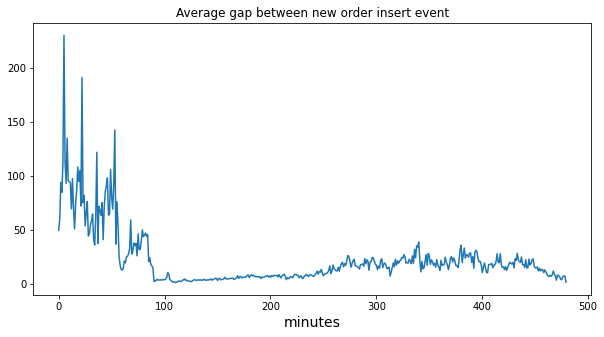

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(minutely_gap.values)
ax.set_title('Average gap between new order insert event')
ax.set_xlabel('minutes', size=14)

In [11]:
duration = pd.read_pickle('order_duration.pkl')
duration = duration[(duration['START'] > start) & (duration['END'] < end)]
duration['duration'] = duration['END'] - duration['START']
all_duration = duration['duration'].values.astype('float64')
b_duration = duration[duration['SIDE'] == 'Buy']['duration'].values.astype('float64')
s_duration = duration[duration['SIDE'] == 'Sell']['duration'].values.astype('float64')

In [12]:
np.quantile(all_duration, [0.25, 0.5, 0.75])*1e-6, np.mean(all_duration)

(array([   8.362631,   90.238061, 1001.352092]), 44538396726.95825)

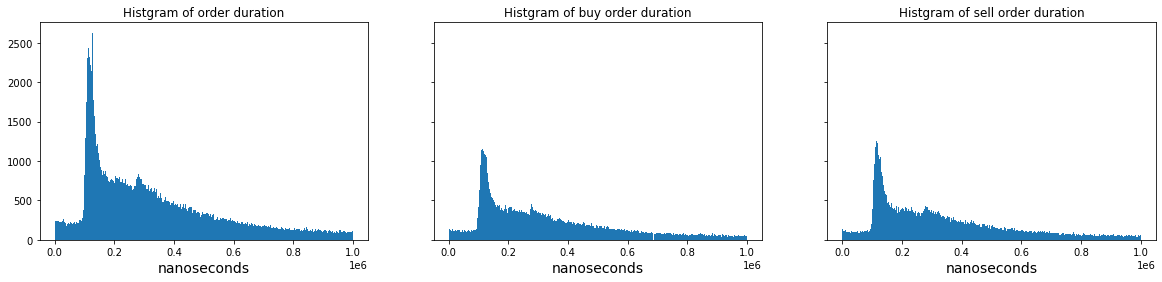

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4), sharey=True)
bins = np.linspace(0, 1e6, 1001)

ax[0].hist(all_duration, bins=bins)
# ax[0].set_ylim((0, 6000))
ax[0].set_title('Histgram of order duration')
ax[0].set_xlabel('nanoseconds', size=14)

ax[1].hist(b_duration, bins=bins)
ax[1].set_title('Histgram of buy order duration')
ax[1].set_xlabel('nanoseconds', size=14)

ax[2].hist(s_duration, bins=bins)
ax[2].set_title('Histgram of sell order duration')
ax[2].set_xlabel('nanoseconds', size=14)

plt.show()

In [ ]:
# https://www.bankofengland.co.uk/prudential-regulation/publication/2022/june/model-risk-management-principles-for-banks
# electronic trading risk principle and federal